## MALIGNANT COMMENTS CLASSIFICATION

1.Import necessary files 

2.Read the csv files 

3.List the various fields in our dataset

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re           # for regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
import pickle

#Importing the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read the csv file into dataframe df
df_train= pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [3]:
print(df_train.shape)

(159571, 8)


##### Observations:
       The training data contains 159,571 observations with 8 columns.

In [4]:
#List the fields in our dataframe
print(df_train.dtypes)

id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object


In [5]:
df_train.id.nunique()

159571

In [6]:
df_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Number of null values:: 0


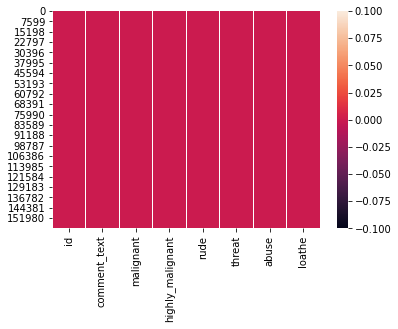

In [7]:
#Checking Null values
print('Number of null values::', df_train['comment_text'].isnull().sum())
sns.heatmap(df_train.isnull())

In [8]:
df_train['non-unique'] = np.where((df_train['malignant'] & df_train['highly_malignant'] == 1) | 
                                 (df_train['malignant'] & df_train['rude'] == 1) | 
                                 (df_train['malignant'] & df_train['threat'] == 1) | 
                                 (df_train['malignant'] & df_train['abuse'] == 1) | 
                                 (df_train['malignant'] & df_train['loathe'] == 1) | 
                                 (df_train['highly_malignant'] & df_train['rude'] == 1) | 
                                 (df_train['highly_malignant'] & df_train['threat'] == 1) | 
                                 (df_train['highly_malignant'] & df_train['abuse'] == 1) | 
                                 (df_train['highly_malignant'] & df_train['loathe'] == 1) | 
                                 (df_train['rude'] & df_train['threat'] == 1) | 
                                 (df_train['rude'] & df_train['abuse'] == 1) | 
                                 (df_train['rude'] & df_train['loathe'] == 1) | 
                                 (df_train['threat'] & df_train['loathe'] == 1) | 
                                 (df_train['threat'] & df_train['abuse'] == 1) | 
                                 (df_train['abuse'] & df_train['loathe'] == 1), 1, 0)
df_train

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,non-unique
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


In [9]:
df_train['non-unique'].value_counts()

0    149706
1      9865
Name: non-unique, dtype: int64

In [10]:
df_train[df_train['non-unique']==1].head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,non-unique
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,1
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,1
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,1


In [11]:
df = df_train.copy()
df.shape

(159571, 9)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
 8   non-unique        159571 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 11.0+ MB


In [13]:
df['comment_text'][5]

'"\n\nCongratulations from me as well, use the tools well. \xa0· talk "'

In [14]:
comment = df['comment_text']
print(comment.head())

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object


In [15]:
df['orginal_length'] = df.comment_text.str.len()
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,non-unique,orginal_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,67


In [16]:
label = df[['malignant','highly_malignant','rude','threat','abuse','loathe']]
print(label.head())
label_count = label.sum()

   malignant  highly_malignant  rude  threat  abuse  loathe
0          0                 0     0       0      0       0
1          0                 0     0       0      0       0
2          0                 0     0       0      0       0
3          0                 0     0       0      0       0
4          0                 0     0       0      0       0


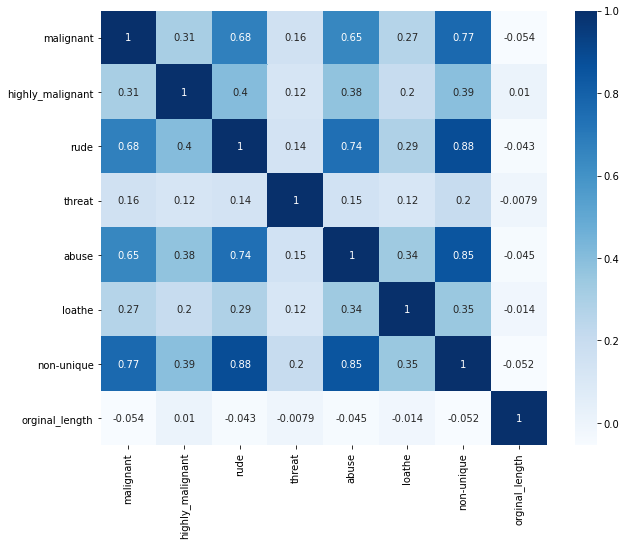

In [17]:
# Cross Correlation matrix across labels

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="Blues")

### Data Visualisations

0    144277
1     15294
Name: malignant, dtype: int64


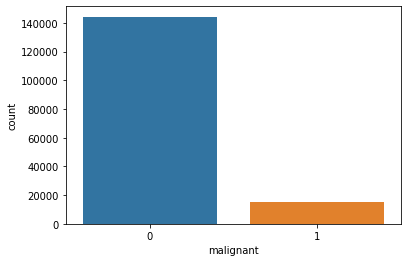

0    157976
1      1595
Name: highly_malignant, dtype: int64


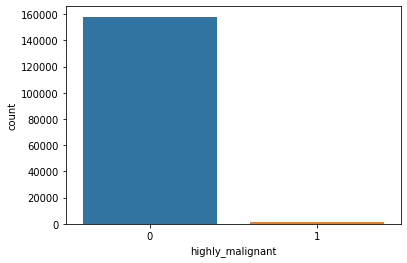

0    158166
1      1405
Name: loathe, dtype: int64


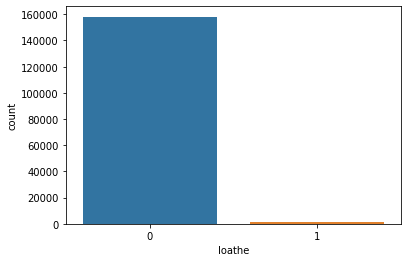

0    151122
1      8449
Name: rude, dtype: int64


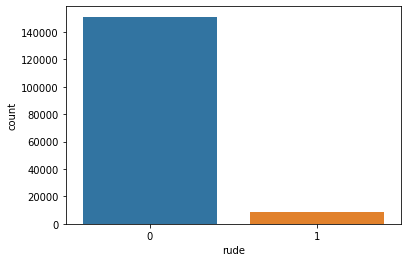

0    151694
1      7877
Name: abuse, dtype: int64


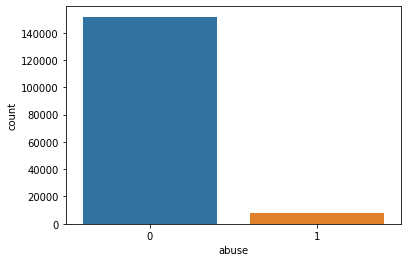

0    159093
1       478
Name: threat, dtype: int64


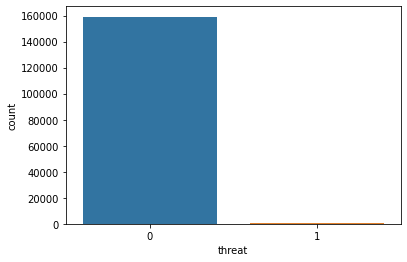

In [18]:
col=['malignant','highly_malignant','loathe','rude','abuse','threat']
for i in col:
    print(df[i].value_counts())
    sns.countplot(df[i])
    plt.show()

#### Let us analyse the no. of comments having lengths varying from 0 to 1200

average length of comment: 394.139


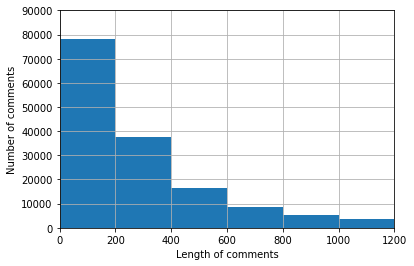

In [19]:
x = [len(comment[i]) for i in range(comment.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

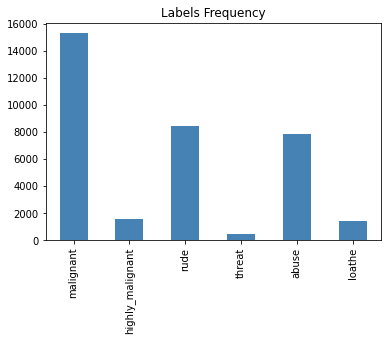

In [20]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

##### Observations:
       Plot for the labeled data frequency. There is significant class imbalance since majority of the comments are considered non-malignant.

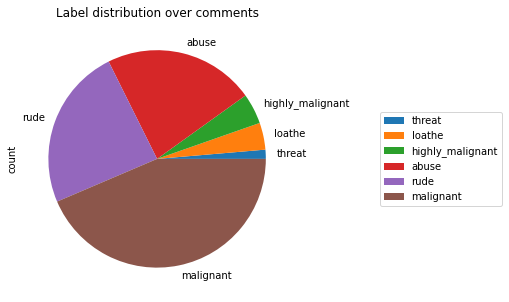

In [21]:
#Labels distribution over comments using pie plot
cols_target = ['malignant','highly_malignant','rude','threat','abuse','loathe']
df_distribution = df[cols_target].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')

df_distribution.plot.pie(y='count',title='Label distribution over comments',figsize=(5, 5)).legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

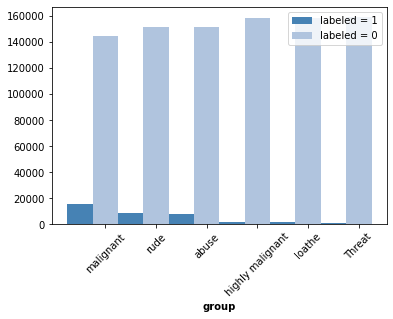

In [22]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.50

bars1 = [sum(df['malignant'] == 1), sum(df['rude'] == 1), sum(df['abuse'] == 1), sum(df['highly_malignant'] == 1),
         sum(df['loathe'] == 1), sum(df['threat'] == 1)]
bars2 = [sum(df['malignant'] == 0), sum(df['rude'] == 0), sum(df['abuse'] == 0), sum(df['highly_malignant'] == 0),
         sum(df['loathe'] == 0), sum(df['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['malignant', 'rude', 'abuse', 'highly malignant', 'loathe',
                                                       'Threat'])
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Preprocessing

#### Preprocessing involved the following steps:

    - Removing Punctuations and other special characters
    - Splitting the comments into individual words
    - Removing Stop Words
    - Stemming and Lemmatising
    - Applying Count Vectoriser
    - Splitting dataset into Training and Testing

In [23]:
import nltk
nltk.download('stopwords')

def clean_text(df, df_column_name):
  # Convert all messages to lower case
  df[df_column_name] = df[df_column_name].str.lower()

  # Replace email addresses with 'email'
  df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                  'emailaddress')

  # Replace URLs with 'webaddress'
  df[df_column_name] = df[df_column_name].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                    'webaddress')

  # Replace money symbols with 'dollars' (£ can by typed with ALT key + 156)
  df[df_column_name] = df[df_column_name].str.replace(r'£|\$', 'dollars')
      
  # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
  df[df_column_name] = df[df_column_name].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                    'phonenumber')

  # Replace numbers with 'numbr'
  df[df_column_name] = df[df_column_name].str.replace(r'\d+(\.\d+)?', 'numbr')

  # Remove punctuation
  df[df_column_name] = df[df_column_name].str.replace(r'[^\w\d\s]', ' ')

  # Replace whitespace between terms with a single space
  df[df_column_name] = df[df_column_name].str.replace(r'\s+', ' ')

  # Remove leading and trailing whitespace
  df[df_column_name] = df[df_column_name].str.replace(r'^\s+|\s+?$', '')
    
  # Remove stopwords
  stop_words = set(stopwords.words('english') + ['u', 'ü', 'â', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
  df[df_column_name] = df[df_column_name].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
clean_text(df, 'comment_text')
df['comment_text'][5]

'congratulations well use tools well talk'

In [27]:
df['new_length'] = df.comment_text.str.len()
df.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,non-unique,orginal_length,new_length
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,264,170
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0,0,112,93
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,0,233,141
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0,0,622,374
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,0,67,29


#### Stemming and Lemmatizing

The wordnet library in nltk will be used for this purpose. Stemmer and Lemmatizer are also imported from nltk.

In [28]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


lem=WordNetLemmatizer()
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join(lem.lemmatize(t) for t in x.split()))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [29]:
df.drop(columns=['orginal_length'], inplace=True)

In [30]:
# dropping id and comment text
df_1 = df.drop(columns=['id', 'comment_text', 'non-unique', 'new_length'])

# Calculating total count of each category comments
counts = []
categories = list(df_1.columns.values)
for i in categories:
    counts.append((i, df_1[i].sum()))
df_stats = pd.DataFrame(counts, columns=['Category', 'Count'])
df_stats

,Category,Count
0,malignant,15294
1,highly_malignant,1595
2,rude,8449
3,threat,478
4,abuse,7877
5,loathe,1405


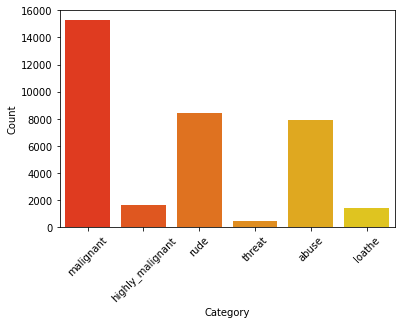

In [31]:
sns.barplot(x='Category', y='Count', data=df_stats, palette='autumn')
plt.xticks(rotation=45)
plt.show()

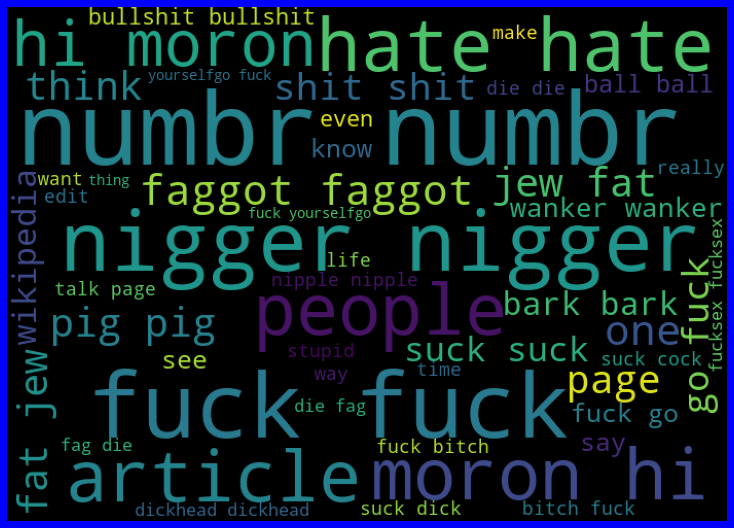

In [32]:
#Getting sense of loud words in malignant 
from wordcloud import WordCloud

malignant = df['comment_text'][df['malignant']==1]
word_cloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(malignant))
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

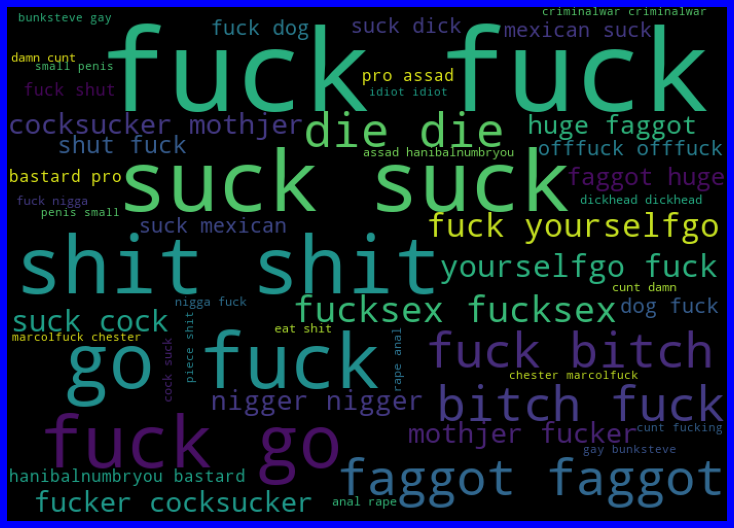

In [33]:
# loud words in Highly_malignant
highly_malignant = df['comment_text'][df['highly_malignant']==1]
word_cloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(highly_malignant))
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

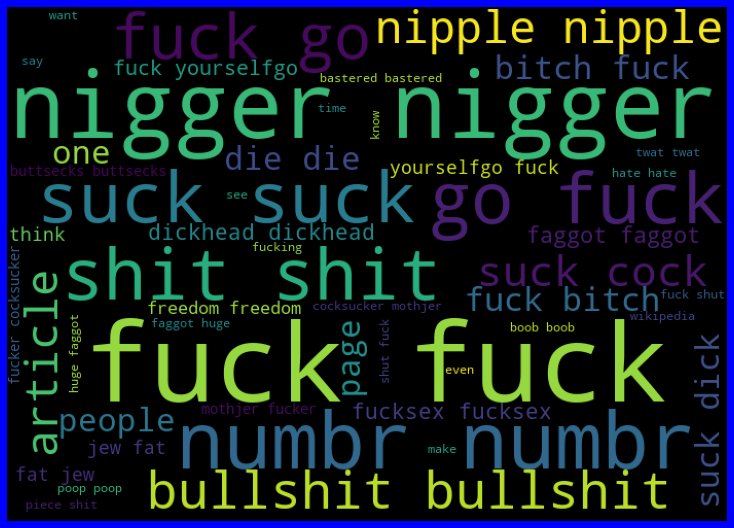

In [34]:
# loud words in Rude 
rude = df['comment_text'][df['rude']==1]
word_cloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(rude))
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

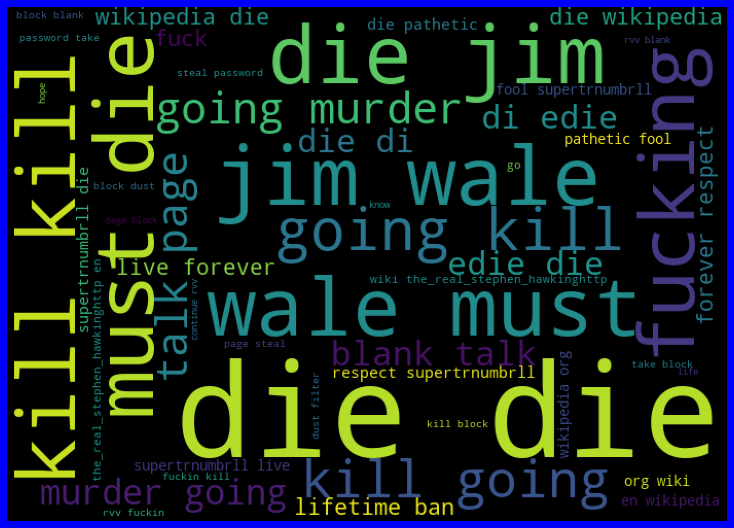

In [35]:
# loud words in Threat
threat = df['comment_text'][df['threat']==1]
word_cloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(threat))
plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

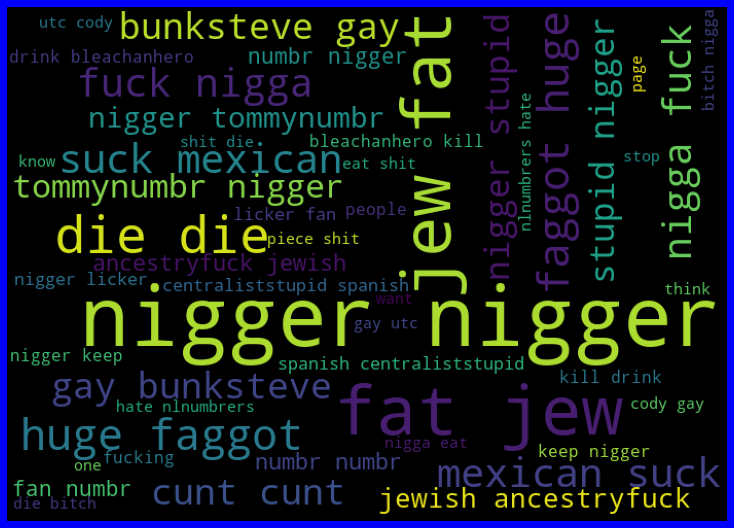

In [36]:
#loud words in Loathe

loathe = df['comment_text'][df['loathe']==1]

word_cloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(loathe))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

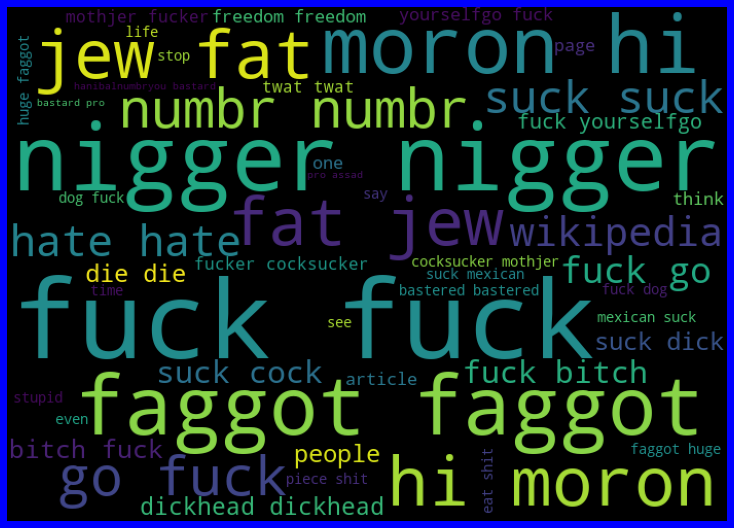

In [37]:
#Loud words in Abuse
abuse = df['comment_text'][df['abuse']==1]

word_cloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(abuse))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Splitting dataset into training and testing

In [38]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

In [39]:
train.shape, test.shape

((106912, 10), (52659, 10))

In [40]:
x_train = train['comment_text']
y_train = train.drop(columns=['comment_text', 'id', 'non-unique', 'new_length'])
x_test = test['comment_text']
y_test = test.drop(columns=['comment_text', 'id', 'non-unique', 'new_length'])

#### Applying Count Vectorizer
Here we can finally convert our comments into a matrix of token counts, which signifies the number of times it occurs.

In [41]:
#import required library
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

#create object
cv = CountVectorizer()
tf = TfidfTransformer()
#fitting 
x_train = tf.fit_transform(cv.fit_transform(x_train))
x_test = tf.transform(cv.transform(x_test))

In [42]:
y_labels = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']
accuracy = [[], [], [], [], []]

#### Implementation :


In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [44]:
MNB = MultinomialNB()

for i in y_labels:
    MNB.fit(x_train, train[i])
    acc = MNB.score(x_test, test[i])
    accuracy[0].append(acc)
    print("{0} accuracy :: {1}%".format(i, round(acc*100,2)))

malignant accuracy :: 92.04%
highly_malignant accuracy :: 99.0%
rude accuracy :: 95.19%
threat accuracy :: 99.71%
abuse accuracy :: 95.19%
loathe accuracy :: 99.1%


In [45]:
KNN = KNeighborsClassifier()

for i in y_labels:
    KNN.fit(x_train, train[i])
    acc = KNN.score(x_test, test[i])
    accuracy[1].append(acc)
    print("{0} accuracy :: {1}%".format(i, round(acc*100,2)))

malignant accuracy :: 87.89%
highly_malignant accuracy :: 98.95%
rude accuracy :: 94.28%
threat accuracy :: 99.71%
abuse accuracy :: 95.58%
loathe accuracy :: 99.15%


In [46]:
SVC = LinearSVC()

for i in y_labels:
    SVC.fit(x_train, train[i])
    acc = SVC.score(x_test, test[i])
    accuracy[2].append(acc)
    print("{0} accuracy :: {1}%".format(i, round(acc*100,2)))

malignant accuracy :: 96.07%
highly_malignant accuracy :: 99.07%
rude accuracy :: 97.9%
threat accuracy :: 99.74%
abuse accuracy :: 97.12%
loathe accuracy :: 99.23%


In [47]:
DTC = DecisionTreeClassifier()

for i in y_labels:
    DTC.fit(x_train, train[i])
    acc = DTC.score(x_test, test[i])
    accuracy[3].append(acc)
    print("{0} accuracy :: {1}%".format(i, round(acc*100,2)))

malignant accuracy :: 94.15%
highly_malignant accuracy :: 98.72%
rude accuracy :: 97.5%
threat accuracy :: 99.65%
abuse accuracy :: 96.22%
loathe accuracy :: 99.02%


In [48]:
lg = LogisticRegression()

for i in y_labels:
    lg.fit(x_train, train[i])
    acc = lg.score(x_test, test[i])
    accuracy[4].append(acc)
    print("{0} accuracy :: {1}%".format(i, round(acc*100,2)))

malignant accuracy :: 95.64%
highly_malignant accuracy :: 99.1%
rude accuracy :: 97.66%
threat accuracy :: 99.73%
abuse accuracy :: 96.97%
loathe accuracy :: 99.19%


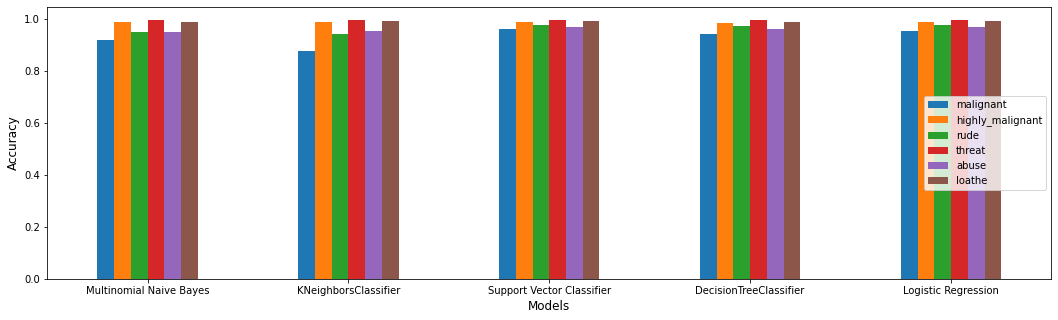

In [49]:
accuracy = pd.DataFrame(accuracy)
fig = accuracy.plot.bar(figsize=(18, 5))
plt.xticks(np.arange(5), ('Multinomial Naive Bayes','KNeighborsClassifier','Support Vector Classifier', 'DecisionTreeClassifier','Logistic Regression'), rotation=0)
plt.legend(y_labels,loc="center right")
plt.xlabel('Models',fontsize='large')
plt.ylabel('Accuracy' ,fontsize='large')
plt.show()

##### Observation:
Based on the above comparison, we could say that for these models with default settings, LinearSVC performs better than anyone for 'malignant' label .

In [50]:
models = ['Multinomial Naive Bayes','KNeighborsClassifier','Support Vector Classifier', 'DecisionTreeClassifier','Logistic Regression']
for i in range(5):
  print(models[i], "- Accuracy -", np.mean(accuracy.iloc[i,:]))

Multinomial Naive Bayes - Accuracy - 0.967052165821607
KNeighborsClassifier - Accuracy - 0.9592820473866448
Support Vector Classifier - Accuracy - 0.9818771086930377
DecisionTreeClassifier - Accuracy - 0.9754173075827494
Logistic Regression - Accuracy - 0.9804718408375903


In [51]:
# Hyperparameter tuning in Linear SVC
from sklearn.model_selection import GridSearchCV

SVC = LinearSVC(random_state=42)
SVC_param={'C':[1,10], 'penalty':['l1','l2']}

svc = GridSearchCV(SVC,SVC_param)
for i in y_labels:
  svc.fit(x_train, train[i])
  print('Best Parameters for {0} is \n{1}\n'.format(i, svc.best_params_))

Best Parameters for malignant is 
{'C': 1, 'penalty': 'l2'}

Best Parameters for highly_malignant is 
{'C': 1, 'penalty': 'l2'}

Best Parameters for rude is 
{'C': 1, 'penalty': 'l2'}

Best Parameters for threat is 
{'C': 1, 'penalty': 'l2'}

Best Parameters for abuse is 
{'C': 1, 'penalty': 'l2'}

Best Parameters for loathe is 
{'C': 1, 'penalty': 'l2'}



In [52]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
SVC = LinearSVC(C=1, random_state=42, penalty='l2')

predictions = {y_labels[0]:[], y_labels[1]:[], y_labels[2]:[], y_labels[3]:[], y_labels[4]:[], y_labels[5]:[]}
f1score, prediction_accuracy = [], []

for i in y_labels:
  SVC.fit(x_train, train[i])
  y_pred = SVC.predict(x_test)
  predictions[i].append(y_pred)
  print(i)
  
  pred_acc = accuracy_score(test[i], y_pred)
  prediction_accuracy.append(pred_acc)
  print("Accuracy -> {0}%".format(round(pred_acc*100,2)))

  fscore = f1_score(test[i], y_pred)
  f1score.append(fscore)
  print("F1 Score -> {0}%".format(round(fscore*100,2)))
  print(confusion_matrix(test[i], y_pred), '\n')
  print("***********************")

malignant
Accuracy -> 96.07%
F1 Score -> 77.26%
[[47069   507]
 [ 1564  3519]] 

***********************
highly_malignant
Accuracy -> 99.07%
F1 Score -> 39.46%
[[52008   125]
 [  366   160]] 

***********************
rude
Accuracy -> 97.9%
F1 Score -> 78.17%
[[49576   252]
 [  853  1978]] 

***********************
threat
Accuracy -> 99.74%
F1 Score -> 36.02%
[[52486    21]
 [  114    38]] 

***********************
abuse
Accuracy -> 97.12%
F1 Score -> 66.9%
[[49607   409]
 [ 1109  1534]] 

***********************
loathe
Accuracy -> 99.23%
F1 Score -> 37.35%
[[52132    56]
 [  350   121]] 

***********************


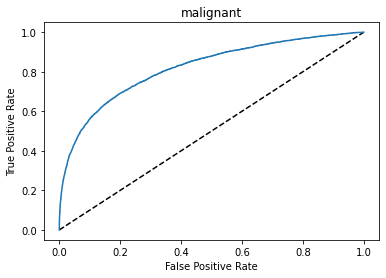

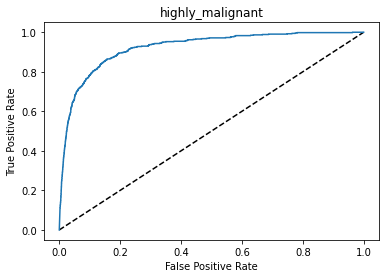

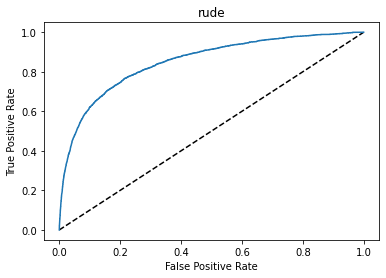

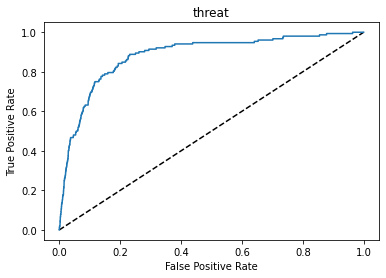

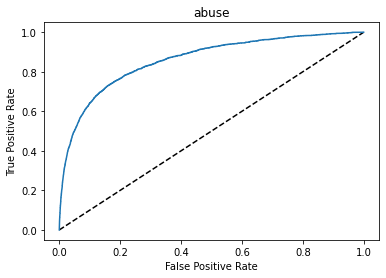

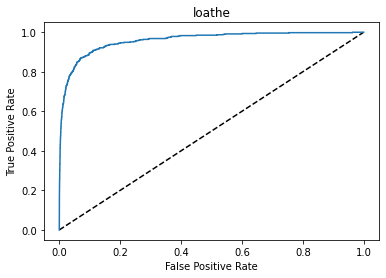

In [53]:
from sklearn.metrics import roc_curve
for i in y_labels:
  y_pred_prob = SVC._predict_proba_lr(x_test)[:, 1]  #1 is the probabilty of threshold value
  fpr, tpr, thresholds=roc_curve(test[i], y_pred_prob)

  plt.plot([0,1],[0,1],'k--')
  plt.plot(fpr, tpr, label=i)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(i)
  plt.show()

In [54]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [55]:
x_train = df['comment_text']
x_train = tf.fit_transform(cv.fit_transform(x_train))

y_train = df.drop(columns=['comment_text', 'id', 'non-unique', 'new_length'])

pred = df_test['comment_text']
pred = tf.transform(cv.transform(pred))

In [56]:
predictions = []
for j, i in enumerate(y_labels):
  SVC.fit(x_train, y_train[i]) # fitting the model
  y_pred = SVC.predict(pred).tolist() # np array of predictions to list
  predictions.append(y_pred)
  print(i, ' Predicted ', round((j+1)/6*100,2), '% ')

malignant  Predicted  16.67 % 
highly_malignant  Predicted  33.33 % 
rude  Predicted  50.0 % 
threat  Predicted  66.67 % 
abuse  Predicted  83.33 % 
loathe  Predicted  100.0 % 


In [57]:
result = pd.DataFrame({'id':df_test['id'], 'comment_text':df_test['comment_text'], 'malignant':predictions[0], 'highly_malignant':predictions[1], 'rude':predictions[2], 'threat':predictions[3], 'abuse':predictions[4], 'loathe':predictions[5]})

In [58]:
result.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,1,0,1,0,1,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,1,0,0,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0,0,0,0


In [60]:
# Saving file
# export to csv
result.to_csv('malignant_comments_classification.csv')